In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import h5py
import torch

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
np.set_printoptions(precision=2, suppress=False)

cuda:0


# Dataset plotting

Text(0, 0.33, '2020 Census')

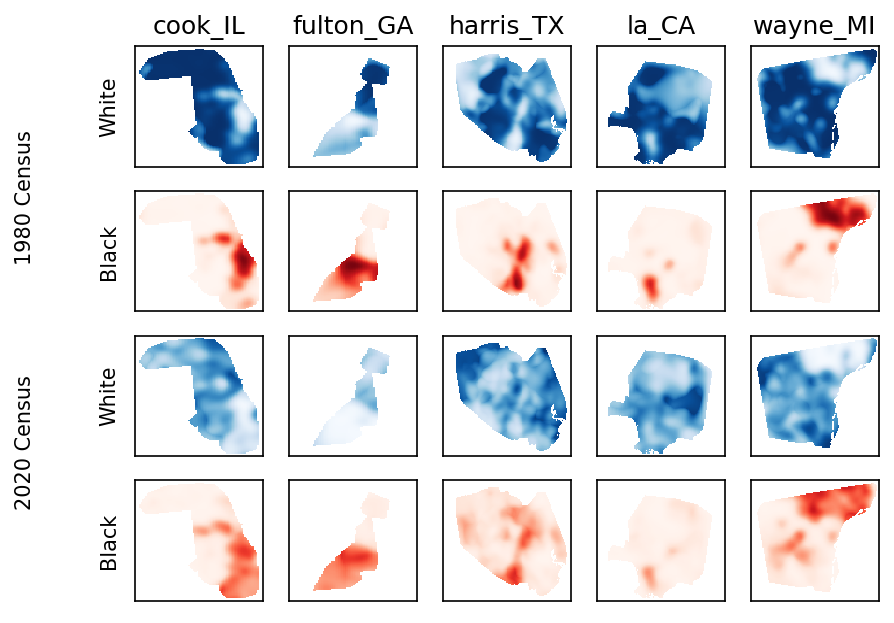

In [2]:
from census_dataset import CensusDataset
from pbnn import *
from torch.utils.data import ConcatDataset

def plot(ax, sample, vmax=None):
    ax[0].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmax=1, vmin=0)
    ax[1].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmax=1, vmin=0)
        
    for a in ax:
        a.set_aspect('equal')
        a.set(xticks=[], yticks=[])
    
dataset = ConcatDataset([
    CensusDataset('cook_IL'),
    CensusDataset('fulton_GA'),
    CensusDataset('harris_TX'),
    CensusDataset('la_CA'),
    CensusDataset('wayne_MI'),
])
fig, ax = plt.subplots(4, 5, dpi=150)
for i, ds in enumerate(dataset.datasets):
    ds.validate()
    sample = dataset[i*40]
    ax[0,i].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmin=0, vmax=1)
    ax[1,i].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmin=0, vmax=1)

    sample = dataset[i*40+39]
    ax[2,i].pcolormesh(sample['x'], sample['y'], sample['wb0'][0], cmap='Blues', vmin=0, vmax=1)
    ax[3,i].pcolormesh(sample['x'], sample['y'], sample['wb0'][1], cmap='Reds', vmin=0, vmax=1)

    ax[0,i].set_title(dataset.datasets[i].county)

for a in ax.flatten():
    a.set(xticks=[], yticks=[])
    
ax[0,0].set_ylabel(f'White')
ax[1,0].set_ylabel(f'Black')
ax[2,0].set_ylabel(f'White')
ax[3,0].set_ylabel(f'Black')

fig.text(0, 0.67, '1980 Census', rotation=90, va='center', ha='left')
fig.text(0, 0.33, '2020 Census', rotation=90, va='center', ha='left')

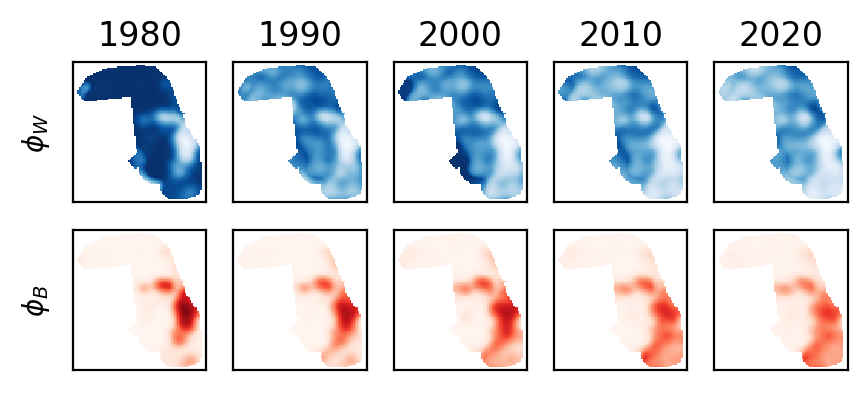

In [17]:
dataset = CensusDataset('cook_IL')
dataset.validate()

fig, ax = plt.subplots(2, 5, figsize=(5, 2), dpi=200)

for i in range(5):
    wb0 = dataset.wb(1980+i*10)
    ax[0,i].set_title(1980+i*10)
    ax[0,i].pcolormesh(dataset.x, dataset.y, wb0[0], vmin=0, vmax=1, cmap='Blues')
    ax[1,i].pcolormesh(dataset.x, dataset.y, wb0[1], vmin=0, vmax=1, cmap='Reds')

    
ax[0,0].set_ylabel('$\phi_W$')
ax[1,0].set_ylabel('$\phi_B$')

for a in ax.flatten():
    a.set(xticks=[], yticks=[])

# Neural network predictions

In [79]:
from census_dataset import CensusDataset
from scipy.interpolate import interp1d

def make_predictions_plot(model, county):
    dataset = CensusDataset(county).validate()
    wb1980 = dataset.wb(1980)
    wb2020 = dataset.wb(2020)

    # Neural network prediction
    ic = dataset[0]
    with torch.no_grad(), d_ad.stop_annotating():
        wbNN = model.simulate(ic, dataset.mesh, device, tmax=40, dt=1).cpu().numpy()

    # Spline extrapolation
    spline = interp1d([1980, 1990], np.stack([dataset.wb(1980), dataset.wb(1990)]), axis=0, fill_value='extrapolate')
    wbSpline = spline(2020)

    # Error rates
    mse_NN = np.mean(np.power(wbNN - wb2020, 2).sum(0)[dataset.mask])
    mse_Sp = np.mean(np.power(wbSpline - wb2020, 2).sum(0)[dataset.mask])
    mse_No = np.mean(np.power(wb1980 - wb2020, 2).sum(0)[dataset.mask])

    print(f'For county = {county}')
    print(f'---------------------------------')
    print(f'\tModel\t\t|   MSE  ')
    print(f'---------------------------------')
    print(f'Neural Network\t\t|  {mse_NN:.3f}')
    print(f'Spline extrapolation\t|  {mse_Sp:.3f}')
    print(f'No dynamics\t\t|  {mse_No:.3f}')

    def plot(column, dataset, wb):
        prop = (wb[0] - wb[1]) / wb.sum(0)
        column[0].pcolormesh(dataset.x, dataset.y, prop, vmin=-1, vmax=1, cmap='bwr_r')
        column[1].pcolormesh(dataset.x, dataset.y,  wb[0], vmin=0, vmax=1, cmap='Blues')
        column[2].pcolormesh(dataset.x, dataset.y,  wb[1], vmin=0, vmax=1, cmap='Reds')

    fig, ax = plt.subplots(3, 4, dpi=200)

    plot(ax[:,0], dataset, wb1980)
    plot(ax[:,1], dataset, wb2020)
    plot(ax[:,2], dataset, wbNN)
    plot(ax[:,3], dataset, wbSpline)

    plt.rcParams['font.size'] = 8
    plt.rcParams['axes.titlesize'] = 8

    fig.colorbar(pc0, ax=ax[0,:], ticks=[-1,1]).set_ticklabels(['All\nblack', 'All\nwhite'], 
        rotation=90, verticalalignment='center', multialignment='center')
    fig.colorbar(pc1, ax=ax[1,:], ticks=[0,1], label='Fraction')
    fig.colorbar(pc2, ax=ax[2,:], ticks=[0,1], label='Fraction')

    ax[0,0].set_title('1980\ncensus data')
    ax[0,1].set_title('2020\ncensus data')
    ax[0,2].set_title('2020\nNN prediction')
    ax[0,3].set_title('2020\nSpline extrapolation')

    ax[0,0].set_ylabel('Resident\nproportion')
    ax[1,0].set_ylabel('White\noccupation')
    ax[2,0].set_ylabel('Black\noccupation')

    for a in ax.flatten():
        a.set(xticks=[], yticks=[], aspect='equal')

    return fig

For county = fulton_GA
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.062
Spline extrapolation	|  0.502
No dynamics		|  0.214


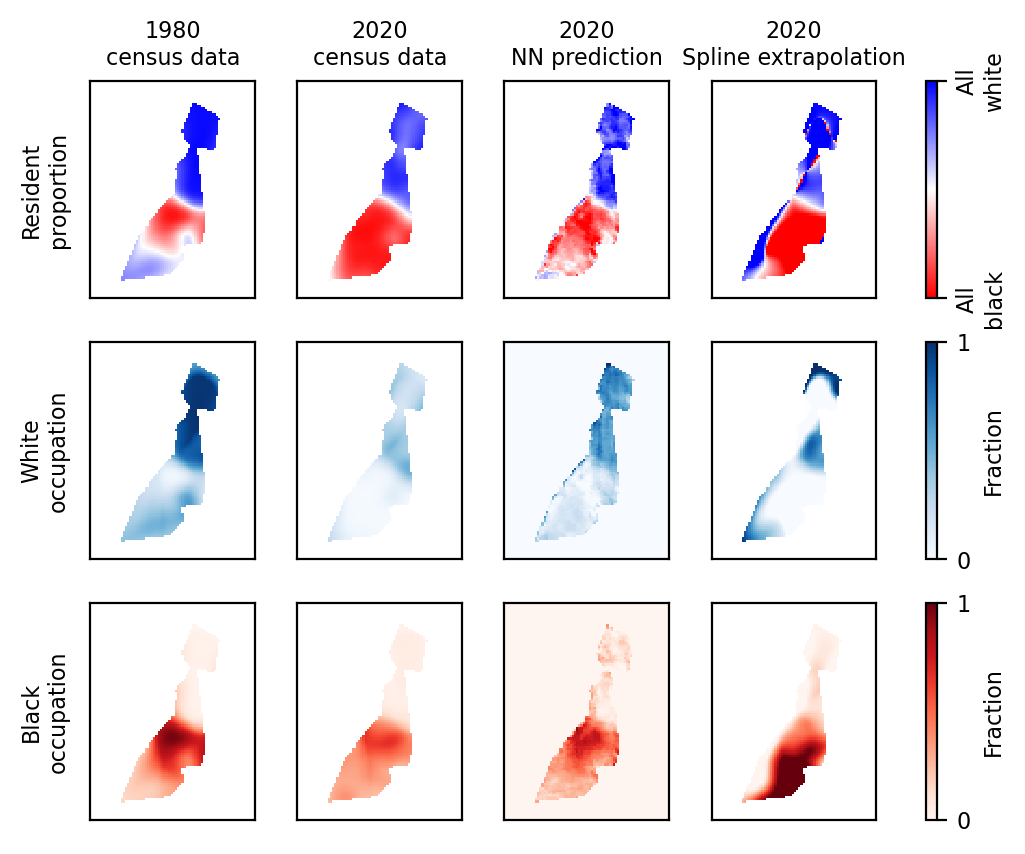

In [74]:
from census_pbnn import CensusPBNN

info = torch.load(f'models/SourcedOnlyPBNN.ckpt')
model = CensusPBNN().to(device)
model.load_state_dict(info['state_dict'], strict=False)

make_predictions_plot(model, 'fulton_GA');

For county = cook_IL
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.048
Spline extrapolation	|  0.594
No dynamics		|  0.226


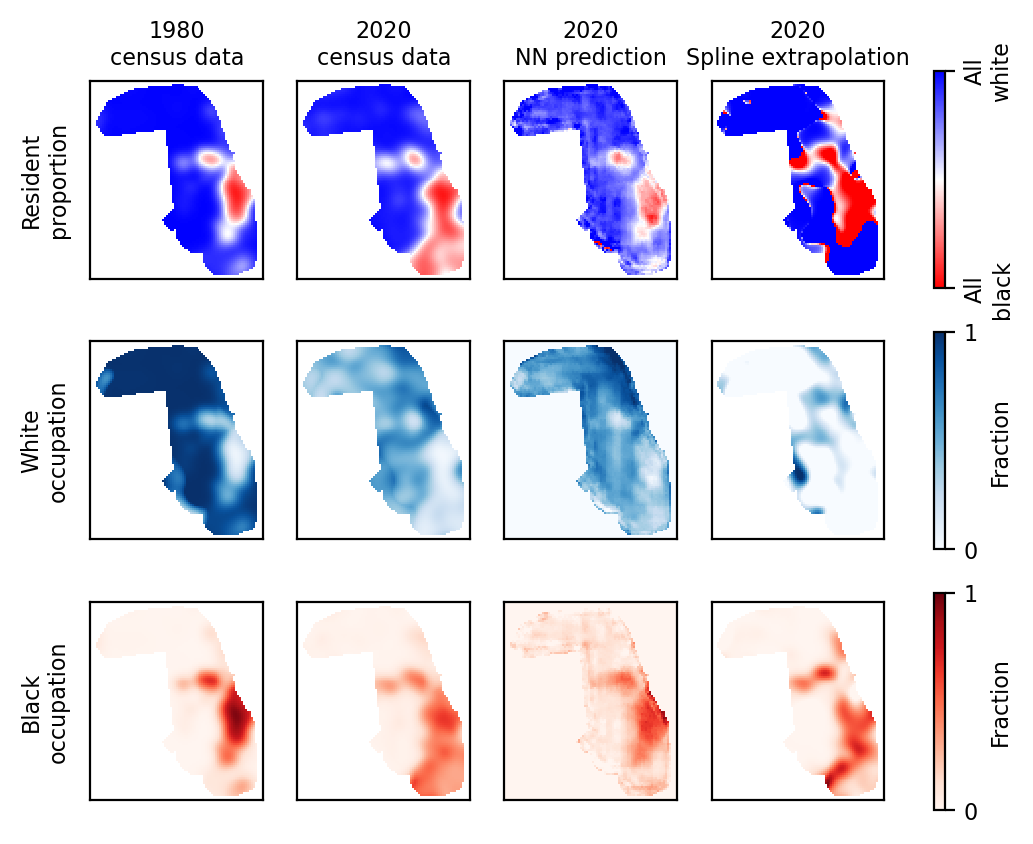

In [75]:
from census_pbnn import CensusPBNN

info = torch.load(f'models/SourcedOnlyPBNN.ckpt')
model = CensusPBNN().to(device)
model.load_state_dict(info['state_dict'], strict=False)

make_predictions_plot(model, 'cook_IL');

For county = harris_TX
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.101
Spline extrapolation	|  0.593
No dynamics		|  0.164


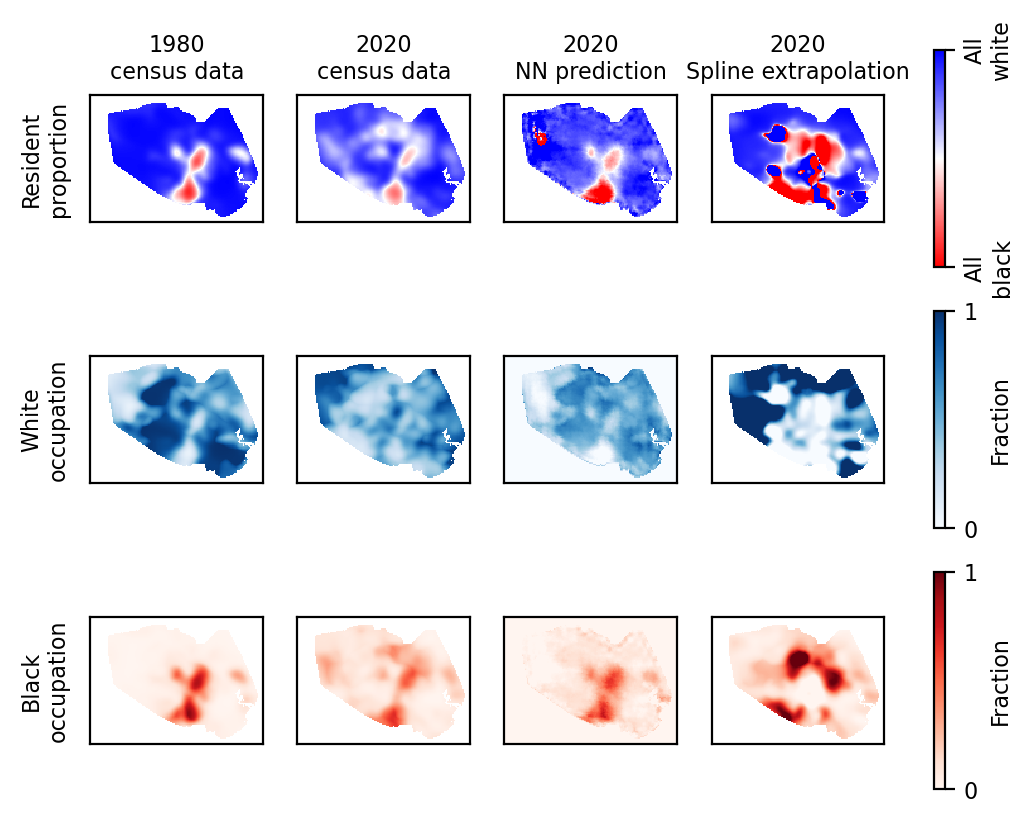

In [77]:
from census_pbnn import CensusPBNN

info = torch.load(f'models/SourcedOnlyPBNN.ckpt')
model = CensusPBNN().to(device)
model.load_state_dict(info['state_dict'], strict=False)

make_predictions_plot(model, 'harris_TX');

For county = la_CA
---------------------------------
	Model		|   MSE  
---------------------------------
Neural Network		|  0.039
Spline extrapolation	|  1.295
No dynamics		|  0.140


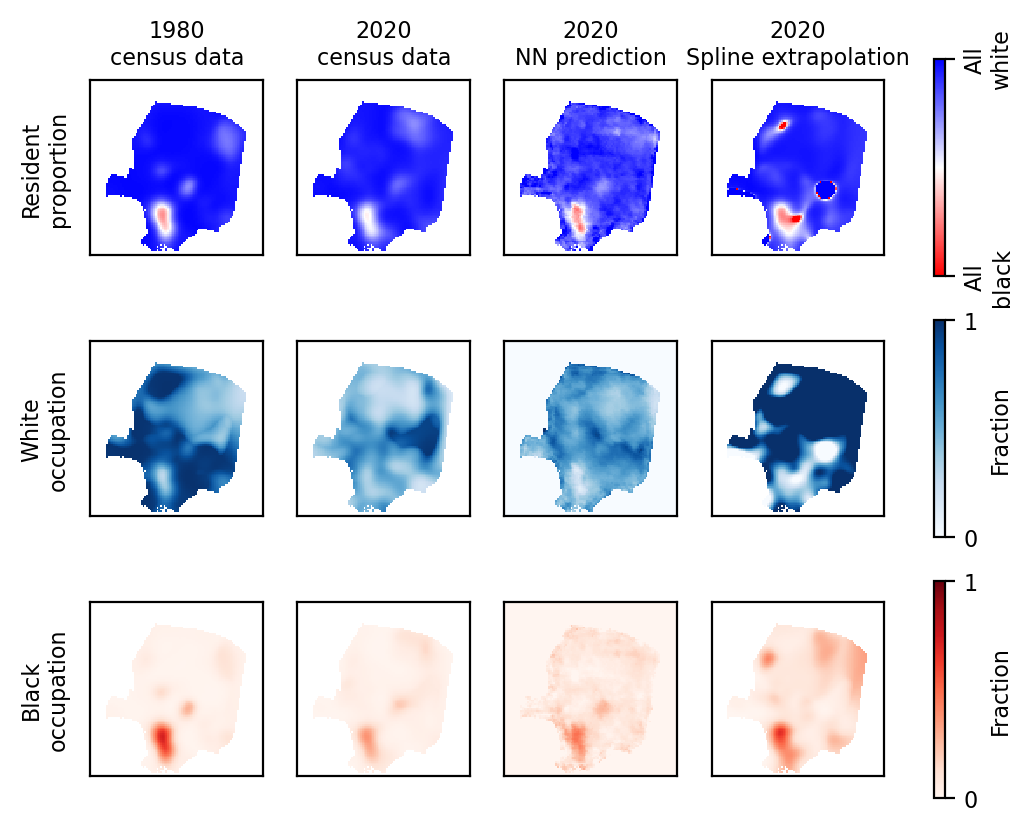

In [78]:
from census_pbnn import CensusPBNN

info = torch.load(f'models/SourcedOnlyPBNN.ckpt')
model = CensusPBNN().to(device)
model.load_state_dict(info['state_dict'], strict=False)

make_predictions_plot(model, 'la_CA');

# Build a spatial saliency map

In [8]:
dataset = ConcatDataset([
    CensusDataset('cook_IL',housing_method=housing_method),
    CensusDataset('fulton_GA',housing_method=housing_method),
    CensusDataset('harris_TX',housing_method=housing_method),
    CensusDataset('la_CA',housing_method=housing_method),
])

info = torch.load(f'models/decennial/SourcedOnlyPBNN.ckpt')

model = DecennialPBNN().to(device)
model.load_state_dict(info['state_dict'], strict=False)
model.train()

for ds in dataset.datasets:
    print(dataset)
    compute_saliency(model, ds, device, 'models/decennial/SourcedOnlyPBNN')

Building dataset with constant housing in time
Building dataset with constant housing in time
Building dataset with constant housing in time
Building dataset with constant housing in time


100%|██████████| 40/40 [00:41<00:00,  1.03s/it]


100%|██████████| 40/40 [01:20<00:00,  2.01s/it]


100%|██████████| 40/40 [01:49<00:00,  2.74s/it]


100%|██████████| 40/40 [00:45<00:00,  1.13s/it]
